<a href="https://colab.research.google.com/github/hisaom0419/my_python/blob/master/Tecan(OD_FL1)_20210429.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [427]:
# from google.colab import drive
# drive.mount('/content/drive')

In [428]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [429]:
%pwd
%cd /content/drive/MyDrive/Colab Notebooks
#%ls

/content/drive/MyDrive/Colab Notebooks


In [430]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import fftpack

In [431]:
#データ読み込み(ver.1.0.0)

data_file = '20210422 trans.xlsx' #データシート
max_cycle = len(pd.read_excel(data_file).columns) #最大読み取りサイクル数
sample_file = 'Sample_sheet.xlsx' #サンプルシート
graph_color = 'red' #グラフの色
graph_file = 'Graph_20210427.pdf' #グラフの保存ファイル名
max_FL_file = 'maxRFP_file.xlsx' #最大蛍光値・MGRを保存するファイル

Sample = pd.read_excel(sample_file, index_col=0).to_dict()["Sample"]
length = len(Sample)

if length == 96:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=46,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=46+96+5,nrows=96,header=None,usecols=np.arange(0,max_cycle,1)).dropna(how='all',axis=1)
  
else:
  df_1 = pd.read_excel(data_file,index_col=0,skiprows=47,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))
  df_2 = pd.read_excel(data_file,index_col=0,skiprows=47+length+5,nrows=length,header=None,usecols=np.arange(0,max_cycle,1))


#ウェル番号とサンプル名をマルチインデックスにしたデータフレームの作成
df_1c = pd.concat([df_1,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1)
df_2c = pd.concat([df_2,pd.read_excel(sample_file, index_col=0)], axis=1, join='inner').set_index('Sample',append=1)

# #df_1をプロット
# df_1s.T.plot(legend=0)

# print(df_1)

In [432]:
#周期（period）検出(ver.1.0.0)

#サイクル数が偶数値でないといけない
Start = 101 #周期検出の最初
End = 400 #周期検出の最後

Threshold = 0.1 #閾値を設定
Max_Cycle = 50 #最大周期を設定

df = df_1.T.loc[Start:End]

if len(df)%2 != 0:
  print('測定サイクル数を偶数値にしてください！')

else:
  all_period = []

  for column_name in df:
    f = df[column_name].values 
    t = np.arange(len(f)) 

    assert t.size == f.size  # 時間軸の長さとデータの長さが同じであることを確認する
    assert np.unique(np.diff(t)).size == 1  # 時間間隔が全て一定であることを確認する

    T = (t[1] - t[0]) * t.size
    period = 1.0 / (np.arange(t.size / 2)[1:] / T)

    # パワースペクトル密度を計算
    f = f - np.average(f)         # 平均をゼロに。
    F = fftpack.fft(f)                          # 高速フーリエ変換
    Po = np.abs(F[1:(t.size // 2)]) ** 2 / T
    
    dominant_periods = [x for x in period[Po > Threshold] if x <= Max_Cycle]

    n=0
    for x in dominant_periods:
      all_period.append(dominant_periods[n])
      n=n+1
  period = round(np.mean(all_period))
  print('周期は',period,'です。')

周期は 50 です。


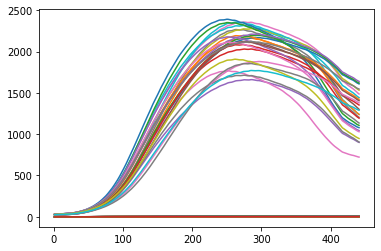

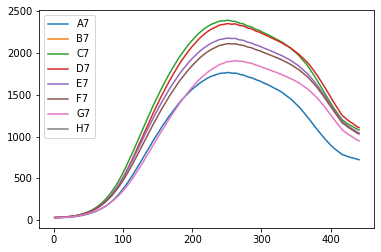

In [433]:
#サイクル処理の確認 (ver.1.0.0)
Df =  df_2c.rolling(period,axis=1,center=True,min_periods=1).mean()
Df.T.plot(legend=0)

#サンプルごとのデータをグラフ化
Df.xs('No.7', level=1).T.plot()

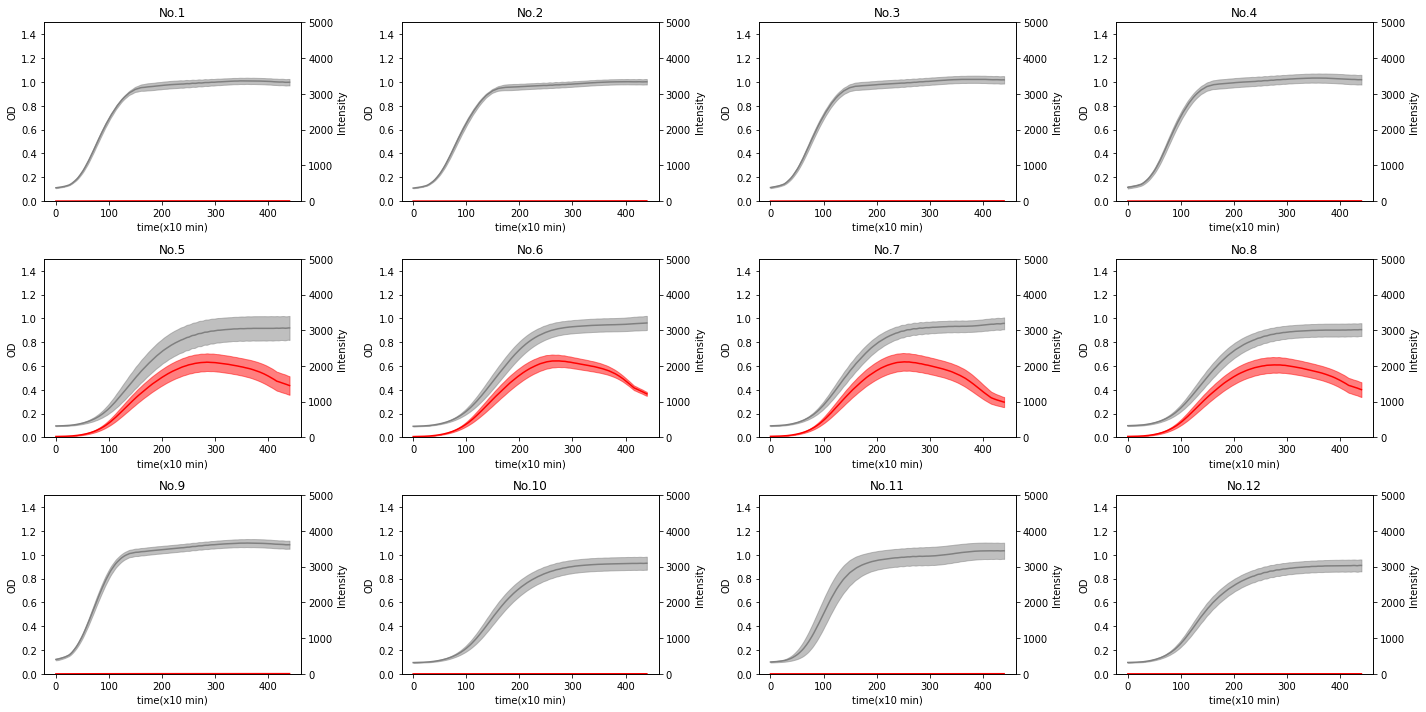

In [434]:
#グラフ一覧作成 (ver.1.0.0)

#グラフの縦軸の最大値
max_OD = 1.5
max_FL = 5000

fig=plt.figure(figsize=(20,10))

#rollingの条件を変更
Df1 =  df_1c.rolling(period,axis=1,center=True,min_periods=1).mean()
Df2 =  df_2c.rolling(period,axis=1,center=True,min_periods=1).mean()

n=0
x=np.arange(len(Df1.T))

for sample in list(Sample.values())[:length//8]:
  n+=1
  #wellを抽出
  wells = [k for k, v in Sample.items() if v == sample]


  tdf1=Df1.loc[wells]
  tdf2=Df2.loc[wells]

  y1=tdf1.mean(axis=0)
  std1=tdf1.std(axis=0)
  y2=tdf2.mean(axis=0)
  std2=tdf2.std(axis=0)
  y3=y2/y1

  ax1=fig.add_subplot(3,4,n)
  
  ax1.plot(x,y1,color="gray")
  ax1.fill_between(x,y1-std1,y1+std1,alpha=0.5,color="gray")
  ax1.set_title(sample)
  ax1.set_ylabel("OD")
  ax1.set_xlabel("time(x10 min)")
  ax1.set_ylim(0, max_OD)
  
  ax2 = ax1.twinx() #2軸のグラフを描くため
  ax2.plot(x,y2,color=graph_color)
  ax2.fill_between(x,y2-std2,y2+std2,alpha=0.5,color=graph_color)
  ax2.set_ylim(0, max_FL)
  #ax2.set_yticks(np.arange(0,2000+1,500))
  ax2.set_ylabel("Intensity")

  # ax3 = ax1.twinx() #2軸のグラフを描くため
  # ax3.plot(x,y3,color='blue')
  # ax3.set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#グラフを保存
fig.savefig(graph_file)

In [435]:
#MGR算出ファイル（ver.1.0.0）。遅いので改良の余地あり

#測定間隔（min）、GRを算出するレンジ、R2の閾値を指定
Period = 10
Range = 27
Threshold = 0.8

#データをログ変換
OD_log2 = np.log2(Df1).dropna()
Max_cycle = len(OD_log2.columns)
Well_Num = len(OD_log2) 
x = np.arange(Range)

GR = OD_log2

#WellごとにTimeウインドウを移動しながらGR（直線回帰の傾き=SlopeとR2を取得）、R2のThreshold以上のSlopeを返す（Threshold以下だと0.01を返す）。
#最終的なGRは測定時間間隔（Period）で割り(min-1)、便宜的に1000をかけている。

Well = 0
while Well < Well_Num:

  Cycle = 0
  Slope = []
  R2 = []

  while Cycle < Max_cycle-Range:
    OD_list = OD_log2.iloc[Well,Cycle:Cycle+Range].values
    
    Slope = np.polyfit(x,OD_list,1)
    R2 = np.corrcoef(x,OD_list)[0][1]**2
    
    if R2 > Threshold:
      GR.iloc[Well,Cycle] = Slope[0]*1000/Period
        
    else:
      GR.iloc[Well,Cycle] = 0.01
    
    Cycle += 1
 
  Well += 1 

MGR = GR.max(axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


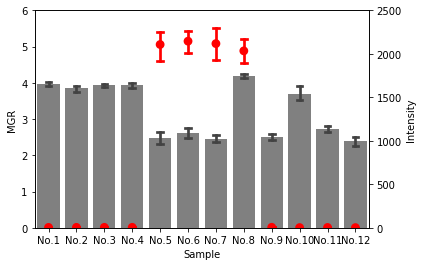

In [436]:
#MGRと最高蛍光値のグラフ化、保存（ver.1.0.0）

MGR_max = 6 #MGRグラフ最大値
MFL_max = 2500 #MFLグラフ最大値

fig=plt.figure()

ax1=fig.add_subplot()
ax1=sns.barplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray',capsize=0.2)
#ax1=sns.stripplot(MGR.index.get_level_values('Sample'), MGR.values,color='gray')
ax1.set_ylabel("MGR")
ax1.set_ylim(0, MGR_max)

MFL = df_2c.rolling(period,axis=1,center=True,min_periods=1).mean().max(axis=1)

ax2 = ax1.twinx() #2軸のグラフを描くため
ax2=sns.pointplot(MFL.index.get_level_values('Sample'), MFL.values,color=graph_color,join=False,capsize=0.2)
#ax2=sns.barplot(MFL.index.get_level_values('Sample'), MFL.values,color=graph_color)

ax2.set_ylabel("Intensity")
ax2.set_ylim(0, MFL_max)

plt.show()

MFL.to_excel(max_FL_file,sheet_name="MFL")
MGR.to_excel(max_FL_file,sheet_name="MGR")